In [1]:
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-11 21:55:38.382594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


# Загружаем массивы из папки cnn_data
X_train_cnn = np.load('cnn_data/X_train_cnn.npy')
X_val_cnn = np.load('cnn_data/X_val_cnn.npy')
X_test_cnn = np.load('cnn_data/X_test_cnn.npy')

y_train = np.load('cnn_data/y_train.npy')
y_val = np.load('cnn_data/y_val.npy')
y_test = np.load('cnn_data/y_test.npy')

In [3]:

# Параметры модели
input_shape = X_train_cnn.shape[1:]  # (25, 16, 1)
print(f"Input shape: {input_shape}")

# Создаем CNN для извлечения признаков
def create_cnn_feature_extractor(input_shape):
    model = models.Sequential(name="CNN_Feature_Extractor")
    
    # Блок 1: Извлечение низкоуровневых признаков
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                           input_shape=input_shape, name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.2, name='dropout1'))
    
    # Блок 2: Извлечение среднеуровневых признаков
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.3, name='dropout2'))
    
    # Блок 3: Извлечение высокоуровневых признаков
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    
    # Слой извлечения признаков (около 5 признаков)
    model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
    model.add(layers.Dropout(0.4, name='dropout3'))
    model.add(layers.Dense(5, activation=None, name='features'))  # 5 признаков без активации
    
    return model

# Создаем полную модель с классификационной головкой
def create_full_model(input_shape):
    # Извлекатель признаков
    feature_extractor = create_cnn_feature_extractor(input_shape)
    
    # Классификационная головка
    classifier_head = models.Sequential([
        layers.Dense(16, activation='relu', name='classifier_dense1'),
        layers.Dropout(0.3, name='classifier_dropout1'),
        layers.Dense(8, activation='relu', name='classifier_dense2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name="Classifier_Head")
    
    # Полная модель
    inputs = layers.Input(shape=input_shape)
    features = feature_extractor(inputs)
    output = classifier_head(features)
    
    full_model = models.Model(inputs=inputs, outputs=output, name="CNN_Classifier")
    
    return full_model, feature_extractor

# Создаем модель
model, feature_extractor = create_full_model(input_shape)

# Компилируем модель
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Выводим архитектуру модели
print("\n" + "="*50)
print("АРХИТЕКТУРА МОДЕЛИ")
print("="*50)
model.summary()

# Дополнительно покажем архитектуру извлекателя признаков
print("\n" + "="*50)
print("АРХИТЕКТУРА ИЗВЛЕКАТЕЛЯ ПРИЗНАКОВ")
print("="*50)
feature_extractor.summary()

# Callbacks для обучения
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Обучение модели
print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ")
print("="*50)

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Оценка на тестовых данных
print("\n" + "="*50)
print("ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")
print("="*50)

test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Input shape: (25, 16, 1)


W0000 00:00:1765479399.306162   44445 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



АРХИТЕКТУРА МОДЕЛИ


Model: "CNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Feature_Extractor           │ (None, 5)              │        97,861 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier_Head (Sequential)    │ (None, 1)              │           241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,102 (383.21 KB)

 Trainable params: 97,654 (381.46 KB)

 Non-trainable params: 448 (1.75 KB)


АРХИТЕКТУРА ИЗВЛЕКАТЕЛЯ ПРИЗНАКОВ


Model: "CNN_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 25, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 25, 16, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 12, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 12, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 12, 8, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 6, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 6, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 6, 4, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense1 (Dense)          │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,861 (382.27 KB)

 Trainable params: 97,413 (380.52 KB)

 Non-trainable params: 448 (1.75 KB)


НАЧАЛО ОБУЧЕНИЯ
Epoch 1/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6553 - loss: 0.6143 - precision: 0.2720 - recall: 0.2339
Epoch 1: val_loss improved from None to 0.60186, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6687 - loss: 0.6057 - precision: 0.2985 - recall: 0.2400 - val_accuracy: 0.7506 - val_loss: 0.6019 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7138 - loss: 0.6106 - precision: 0.4016 - recall: 0.2291
Epoch 2: val_loss improved from 0.60186 to 0.55995, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7277 - loss: 0.5752 - precision: 0.4113 - recall: 0.2040 - val_accuracy: 0.7506 - val_loss: 0.5599 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7778 - loss: 0.5068 - precision: 0.6028 - recall: 0.2239
Epoch 3: val_loss did not improve from 0.55995
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7738 - loss: 0.5193 - precision: 0.6304 - recall: 0.2320 - val_accuracy: 0.7506 - val_loss: 0.5604 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7808 - loss: 0.4806 - precision: 0.5327 - recall: 0.2163
Epoch 4: val_loss improved from 0.55995 to 0.55972, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7798 - loss: 0.4764 - precision: 0.6500 - recall: 0.2600 - val_accuracy: 0.7506 - val_loss: 0.5597 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7830 - loss: 0.4773 - precision: 0.6519 - recall: 0.3808
Epoch 5: val_loss improved from 0.55972 to 0.55026, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7888 - loss: 0.4710 - precision: 0.6309 - recall: 0.3760 - val_accuracy: 0.7506 - val_loss: 0.5503 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7927 - loss: 0.4669 - precision: 0.6560 - recall: 0.3907
Epoch 6: val_loss improved from 0.55026 to 0.53341, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8018 - loss: 0.4572 - precision: 0.7031 - recall: 0.3600 - val_accuracy: 0.7506 - val_loss: 0.5334 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8165 - loss: 0.4368 - precision: 0.7012 - recall: 0.4511
Epoch 7: val_loss improved from 0.53341 to 0.51108, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8058 - loss: 0.4366 - precision: 0.6892 - recall: 0.4080 - val_accuracy: 0.7599 - val_loss: 0.5111 - val_precision: 1.0000 - val_recall: 0.0374 - learning_rate: 0.0010
Epoch 8/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8237 - loss: 0.4302 - precision: 0.7873 - recall: 0.4452
Epoch 8: val_loss improved from 0.51108 to 0.46882, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8138 - loss: 0.4269 - precision: 0.7254 - recall: 0.4120 - val_accuracy: 0.7879 - val_loss: 0.4688 - val_precision: 1.0000 - val_recall: 0.1495 - learning_rate: 0.0010
Epoch 9/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8121 - loss: 0.3935 - precision: 0.6865 - recall: 0.4313
Epoch 9: val_loss did not improve from 0.46882
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8118 - loss: 0.4285 - precision: 0.7183 - recall: 0.4080 - val_accuracy: 0.7902 - val_loss: 0.4828 - val_precision: 1.0000 - val_recall: 0.1589 - learning_rate: 0.0010
Epoch 10/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8493 - loss: 0.4117 - precision: 0.8843 - recall: 0.4405
Epoch 10: val_loss improved from 0.46882 to 0.46416, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8408 - loss: 0.4117 - precision: 0.8527 - recall: 0.4400 - val_accuracy: 0.8112 - val_loss: 0.4642 - val_precision: 1.0000 - val_recall: 0.2430 - learning_rate: 0.0010
Epoch 11/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8460 - loss: 0.3621 - precision: 0.8501 - recall: 0.4838
Epoch 11: val_loss improved from 0.46416 to 0.42539, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8448 - loss: 0.3594 - precision: 0.7950 - recall: 0.5120 - val_accuracy: 0.8112 - val_loss: 0.4254 - val_precision: 1.0000 - val_recall: 0.2430 - learning_rate: 0.0010
Epoch 12/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8462 - loss: 0.3593 - precision: 0.8085 - recall: 0.4877
Epoch 12: val_loss improved from 0.42539 to 0.41452, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8448 - loss: 0.3623 - precision: 0.8276 - recall: 0.4800 - val_accuracy: 0.8089 - val_loss: 0.4145 - val_precision: 0.9032 - val_recall: 0.2617 - learning_rate: 0.0010
Epoch 13/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8651 - loss: 0.3366 - precision: 0.8438 - recall: 0.5481
Epoch 13: val_loss improved from 0.41452 to 0.37372, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8549 - loss: 0.3520 - precision: 0.8221 - recall: 0.5360 - val_accuracy: 0.8252 - val_loss: 0.3737 - val_precision: 0.7963 - val_recall: 0.4019 - learning_rate: 0.0010
Epoch 14/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8571 - loss: 0.3410 - precision: 0.8202 - recall: 0.5748
Epoch 14: val_loss improved from 0.37372 to 0.35826, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8659 - loss: 0.3362 - precision: 0.8222 - recall: 0.5920 - val_accuracy: 0.8508 - val_loss: 0.3583 - val_precision: 0.8644 - val_recall: 0.4766 - learning_rate: 0.0010
Epoch 15/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8602 - loss: 0.3444 - precision: 0.8396 - recall: 0.5922
Epoch 15: val_loss improved from 0.35826 to 0.34480, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8619 - loss: 0.3293 - precision: 0.8256 - recall: 0.5680 - val_accuracy: 0.8275 - val_loss: 0.3448 - val_precision: 0.7463 - val_recall: 0.4673 - learning_rate: 0.0010
Epoch 16/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8665 - loss: 0.3176 - precision: 0.8391 - recall: 0.5970
Epoch 16: val_loss improved from 0.34480 to 0.32634, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8699 - loss: 0.3088 - precision: 0.8529 - recall: 0.5800 - val_accuracy: 0.8531 - val_loss: 0.3263 - val_precision: 0.8548 - val_recall: 0.4953 - learning_rate: 0.0010
Epoch 17/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8751 - loss: 0.2900 - precision: 0.8626 - recall: 0.6482
Epoch 17: val_loss improved from 0.32634 to 0.31440, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8839 - loss: 0.2730 - precision: 0.8454 - recall: 0.6560 - val_accuracy: 0.8671 - val_loss: 0.3144 - val_precision: 0.8676 - val_recall: 0.5514 - learning_rate: 0.0010
Epoch 18/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8778 - loss: 0.3125 - precision: 0.8505 - recall: 0.5985
Epoch 18: val_loss did not improve from 0.31440
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8779 - loss: 0.3155 - precision: 0.8596 - recall: 0.6120 - val_accuracy: 0.8228 - val_loss: 0.3840 - val_precision: 0.6703 - val_recall: 0.5701 - learning_rate: 0.0010
Epoch 19/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8910 - loss: 0.2497 - precision: 0.8722 - recall: 0.6520
Epoch 19: val_loss did not improve from 0.31440
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8819 - loss: 0.2727 - precision: 0.8667 - recall: 0.6240 - val_accuracy: 0.8485 - val_loss: 0.3584 - val_precision: 0.8889 - val_recall: 0.4486 - learning_rate:

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8929 - loss: 0.2393 - precision: 0.8824 - recall: 0.6600 - val_accuracy: 0.8625 - val_loss: 0.3115 - val_precision: 0.8333 - val_recall: 0.5607 - learning_rate: 0.0010
Epoch 22/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8889 - loss: 0.2704 - precision: 0.8554 - recall: 0.7230
Epoch 22: val_loss did not improve from 0.31154
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8919 - loss: 0.2586 - precision: 0.8287 - recall: 0.7160 - val_accuracy: 0.8392 - val_loss: 0.3839 - val_precision: 0.7209 - val_recall: 0.5794 - learning_rate: 0.0010
Epoch 23/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8903 - loss: 0.2329 - precision: 0.8494 - recall: 0.6443
Epoch 23: val_loss improved from 0.31154 to 0.29408, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8879 - loss: 0.2348 - precision: 0.8520 - recall: 0.6680 - val_accuracy: 0.8788 - val_loss: 0.2941 - val_precision: 0.8873 - val_recall: 0.5888 - learning_rate: 0.0010
Epoch 24/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9065 - loss: 0.2192 - precision: 0.8787 - recall: 0.7178
Epoch 24: val_loss did not improve from 0.29408
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8999 - loss: 0.2291 - precision: 0.8989 - recall: 0.6760 - val_accuracy: 0.8671 - val_loss: 0.3174 - val_precision: 0.8125 - val_recall: 0.6075 - learning_rate: 0.0010
Epoch 25/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9143 - loss: 0.2053 - precision: 0.8894 - recall: 0.7565
Epoch 25: val_loss did not improve from 0.29408
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9049 - loss: 0.2216 - precision: 0.8708 - recall: 0.7280 - val_accuracy: 0.8741 - val_loss: 0.3327 - val_precision: 0.8955 - val_recall: 0.5607 - learning_rate:

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9139 - loss: 0.2082 - precision: 0.8981 - recall: 0.7400 - val_accuracy: 0.9044 - val_loss: 0.2928 - val_precision: 0.8667 - val_recall: 0.7290 - learning_rate: 0.0010
Epoch 28/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9072 - loss: 0.1978 - precision: 0.8502 - recall: 0.7740
Epoch 28: val_loss did not improve from 0.29280
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9129 - loss: 0.2008 - precision: 0.8826 - recall: 0.7520 - val_accuracy: 0.8765 - val_loss: 0.2961 - val_precision: 0.7812 - val_recall: 0.7009 - learning_rate: 0.0010
Epoch 29/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9180 - loss: 0.1898 - precision: 0.9152 - recall: 0.7653
Epoch 29: val_loss did not improve from 0.29280
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9229 - loss: 0.1797 - precision: 0.9179 - recall: 0.7600 - val_accuracy: 0.8998 - val_loss: 0.3126 - val_precision: 0.8478 - val_recall: 0.7290 - learning_rate:

## Попытка намутить кроссвалидацию

Данные для кросс-валидации:
X_cv shape: (1428, 25, 16, 1)
y_cv shape: (1428,)

НАЧАЛО 5-КРАТНОЙ СТРАТИФИЦИРОВАННОЙ КРОСС-ВАЛИДАЦИИ

Fold 1/5
Train samples: 1142 (0: 840, 1: 302)
Val samples: 286 (0: 210, 1: 76)


/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       210
           1       0.89      0.71      0.79        76

    accuracy                           0.90       286
   macro avg       0.89      0.84      0.86       286
weighted avg       0.90      0.90      0.89       286

Confusion Matrix:
[[203   7]
 [ 22  54]]

Fold 2/5
Train samples: 1142 (0: 840, 1: 302)
Val samples: 286 (0: 210, 1: 76)


/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       210
           1       0.92      0.76      0.83        76

    accuracy                           0.92       286
   macro avg       0.92      0.87      0.89       286
weighted avg       0.92      0.92      0.92       286

Confusion Matrix:
[[205   5]
 [ 18  58]]

Fold 3/5
Train samples: 1142 (0: 840, 1: 302)
Val samples: 286 (0: 210, 1: 76)


/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       210
           1       0.92      0.87      0.89        76

    accuracy                           0.94       286
   macro avg       0.93      0.92      0.93       286
weighted avg       0.94      0.94      0.94       286

Confusion Matrix:
[[204   6]
 [ 10  66]]

Fold 4/5
Train samples: 1143 (0: 840, 1: 303)
Val samples: 285 (0: 210, 1: 75)


/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 4 - Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       210
           1       0.94      0.84      0.89        75

    accuracy                           0.94       285
   macro avg       0.94      0.91      0.92       285
weighted avg       0.94      0.94      0.94       285

Confusion Matrix:
[[206   4]
 [ 12  63]]

Fold 5/5
Train samples: 1143 (0: 840, 1: 303)
Val samples: 285 (0: 210, 1: 75)


/home/pingvin/Termogramm_My/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Fold 5 - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       210
           1       0.80      0.80      0.80        75

    accuracy                           0.89       285
   macro avg       0.86      0.86      0.86       285
weighted avg       0.89      0.89      0.89       285

Confusion Matrix:
[[195  15]
 [ 15  60]]

ИТОГИ КРОСС-ВАЛИДАЦИИ

Средние показатели по 5 фолдам:
Loss:      0.2236 ± 0.0262
Accuracy:  0.9202 ± 0.0212
Precision: 0.8926 ± 0.0495
Recall:    0.7964 ± 0.0558
F1-Score:  0.8404 ± 0.0430

Детали по фолдам:
Fold 1: Loss=0.2568, Acc=0.8986, Prec=0.8852, Rec=0.7105, F1=0.7883
Fold 2: Loss=0.2400, Acc=0.9196, Prec=0.9206, Rec=0.7632, F1=0.8345
Fold 3: Loss=0.2092, Acc=0.9441, Prec=0.9167, Rec=0.8684, F1=0.8919
Fold 4: Loss=0.1810, Acc=0.9439, Prec=0.9403, Rec=0.8400, F1=0.8873
Fold 5: Loss=0.2309, Acc=0.8947, Prec=0.8000, Rec=0.8000, F1=0.8000

Лучшая модель: Fold 3
Accuracy: 0.9441

ОЦЕНКА Л

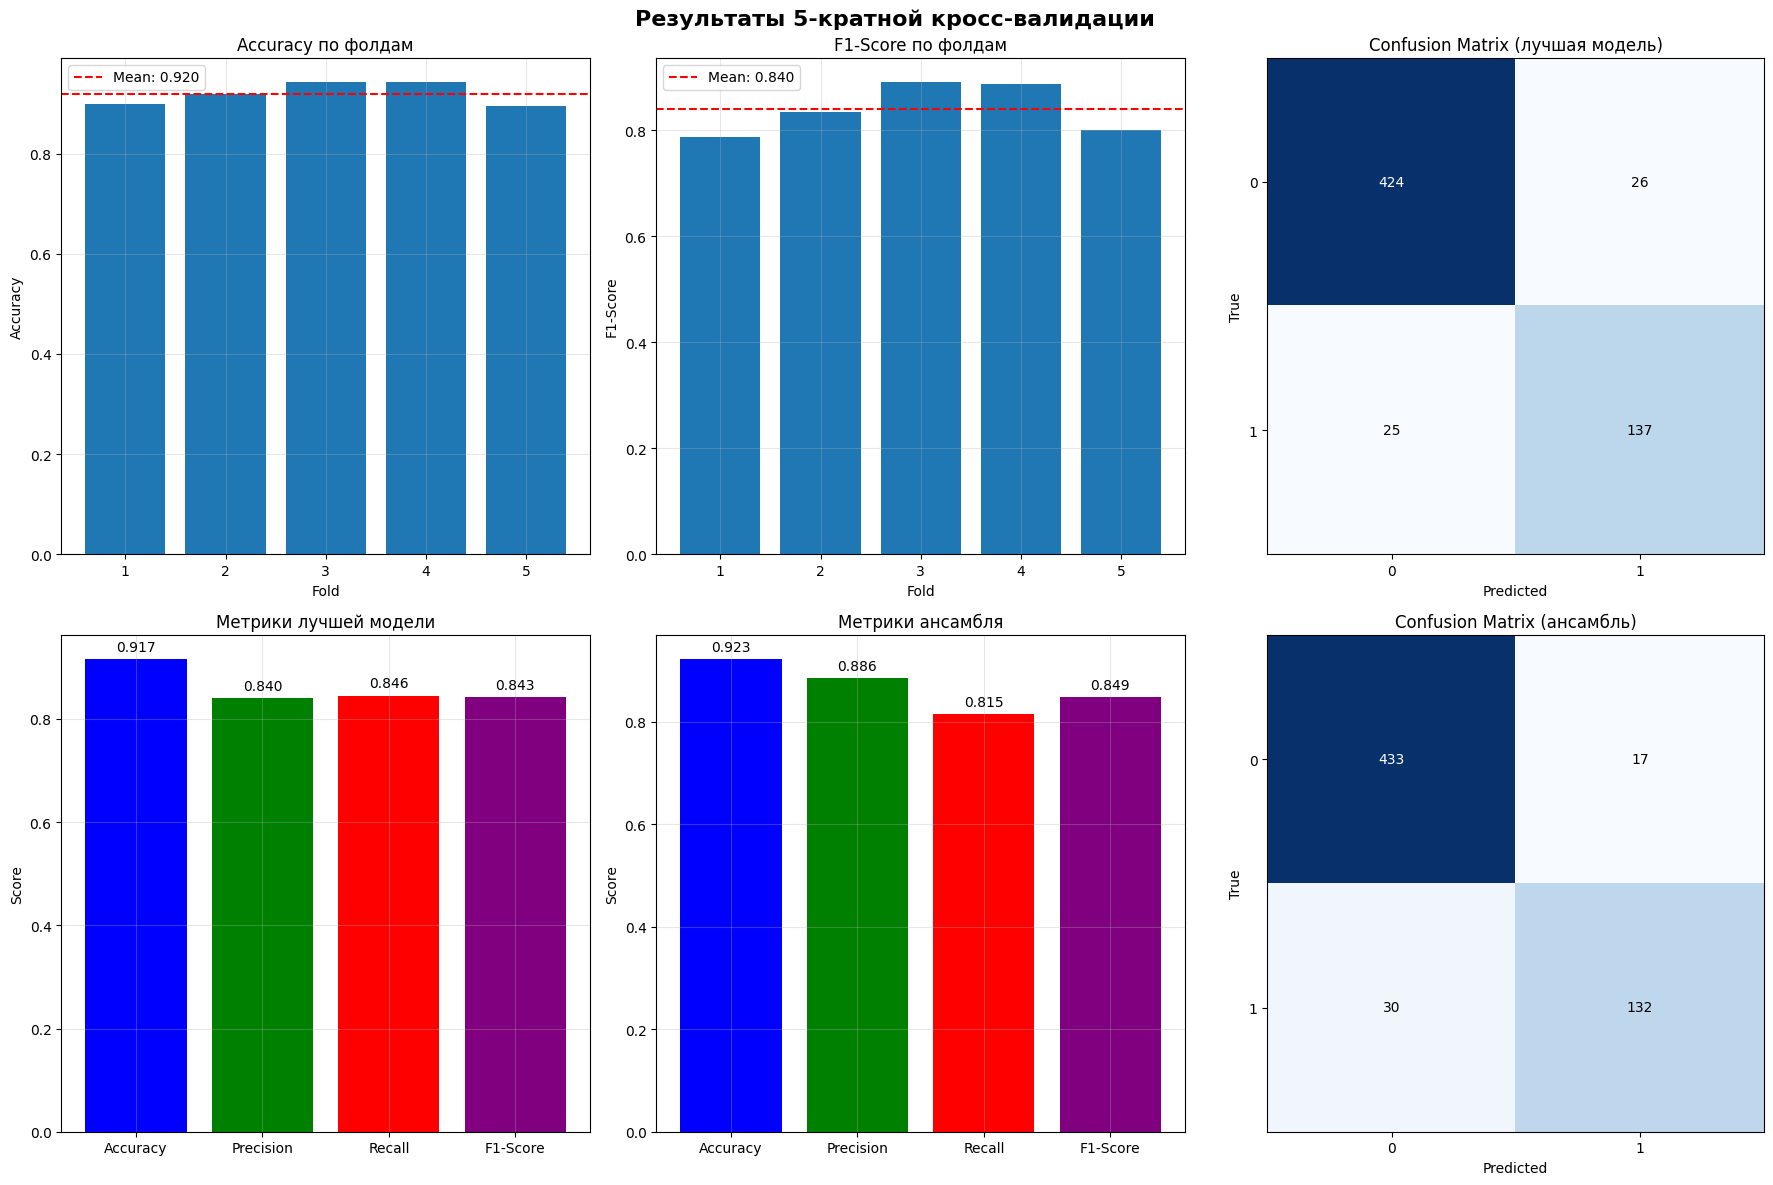

In [ ]:
# Объединяем train и val для кросс-валидации
X_cv = np.concatenate([X_train_cnn, X_val_cnn], axis=0)
y_cv = np.concatenate([y_train, y_val], axis=0)

print(f"Данные для кросс-валидации:")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")

# Стратифицированная кросс-валидация (сохраняем распределение классов)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Функция создания модели
def create_cnn_model(input_shape):
    model = models.Sequential([
        # Блок 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Блок 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Блок 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        
        # Извлечение признаков (5 признаков)
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(5, activation=None, name='features'),
        
        # Классификационная головка
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Массивы для хранения результатов
cv_scores = []
cv_histories = []
cv_models = []
cv_reports = []

# Кросс-валидация
print(f"\n{'='*60}")
print(f"НАЧАЛО {n_splits}-КРАТНОЙ СТРАТИФИЦИРОВАННОЙ КРОСС-ВАЛИДАЦИИ")
print(f"{'='*60}")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv), 1):
    print(f"\n{'='*50}")
    print(f"Fold {fold}/{n_splits}")
    print(f"{'='*50}")
    
    # Разделение данных для текущего фолда
    X_train_fold = X_cv[train_idx]
    y_train_fold = y_cv[train_idx]
    X_val_fold = X_cv[val_idx]
    y_val_fold = y_cv[val_idx]
    
    print(f"Train samples: {len(X_train_fold)} (0: {np.sum(y_train_fold==0)}, 1: {np.sum(y_train_fold==1)})")
    print(f"Val samples: {len(X_val_fold)} (0: {np.sum(y_val_fold==0)}, 1: {np.sum(y_val_fold==1)})")
    
    # Создание и компиляция модели для фолда
    model = create_cnn_model(X_train_cnn.shape[1:])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    ]
    
    # Обучение
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    # Предсказания на валидационном наборе
    y_val_pred_proba = model.predict(X_val_fold, verbose=0)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int).flatten()
    
    # Полный classification report
    report = classification_report(y_val_fold, y_val_pred, output_dict=True)
    cv_reports.append(report)
    
    # Метрики
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_precision = precision_score(y_val_fold, y_val_pred)
    val_recall = recall_score(y_val_fold, y_val_pred)
    val_f1 = f1_score(y_val_fold, y_val_pred)
    
    # Сохраняем результаты
    cv_scores.append({
        'fold': fold,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })
    
    cv_histories.append(history)
    cv_models.append(model)
    
    print(f"\nFold {fold} - Classification Report:")
    print(classification_report(y_val_fold, y_val_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_val_fold, y_val_pred)
    print(f"Confusion Matrix:")
    print(cm)

# Вывод итогов кросс-валидации
print(f"\n{'='*60}")
print("ИТОГИ КРОСС-ВАЛИДАЦИИ")
print(f"{'='*60}")

# Статистика по фолдам
val_losses = [score['val_loss'] for score in cv_scores]
val_accuracies = [score['val_accuracy'] for score in cv_scores]
val_precisions = [score['val_precision'] for score in cv_scores]
val_recalls = [score['val_recall'] for score in cv_scores]
val_f1s = [score['val_f1'] for score in cv_scores]

print(f"\nСредние показатели по {n_splits} фолдам:")
print(f"Loss:      {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
print(f"Accuracy:  {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
print(f"Precision: {np.mean(val_precisions):.4f} ± {np.std(val_precisions):.4f}")
print(f"Recall:    {np.mean(val_recalls):.4f} ± {np.std(val_recalls):.4f}")
print(f"F1-Score:  {np.mean(val_f1s):.4f} ± {np.std(val_f1s):.4f}")

print(f"\nДетали по фолдам:")
for score in cv_scores:
    print(f"Fold {score['fold']}: "
          f"Loss={score['val_loss']:.4f}, "
          f"Acc={score['val_accuracy']:.4f}, "
          f"Prec={score['val_precision']:.4f}, "
          f"Rec={score['val_recall']:.4f}, "
          f"F1={score['val_f1']:.4f}")

# Выбор лучшей модели (по валидационной accuracy)
best_fold_idx = np.argmax(val_accuracies)
best_model = cv_models[best_fold_idx]
print(f"\nЛучшая модель: Fold {best_fold_idx + 1}")
print(f"Accuracy: {val_accuracies[best_fold_idx]:.4f}")

# Оценка лучшей модели на тестовом наборе
print(f"\n{'='*60}")
print("ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ")
print(f"{'='*60}")

# Предсказания на тестовом наборе
y_test_pred_proba = best_model.predict(X_test_cnn, verbose=0)
y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()

# Полный classification report для тестовых данных
print("\nClassification Report для тестовых данных (лучшая модель):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix для тестовых данных
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"Confusion Matrix для тестовых данных:")
print(cm_test)

# Детальные метрики
test_loss, test_acc = best_model.evaluate(X_test_cnn, y_test, verbose=0)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"\nМетрики лучшей модели на тестовых данных:")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision:{test_precision:.4f}")
print(f"Test Recall:   {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Ансамбль моделей (среднее предсказание всех моделей)
print(f"\n{'='*60}")
print("АНСАМБЛЬ МОДЕЛЕЙ (СРЕДНЕЕ ПРЕДСКАЗАНИЕ)")
print(f"{'='*60}")

# Собираем предсказания всех моделей
all_predictions = []
for i, model in enumerate(cv_models):
    predictions = model.predict(X_test_cnn, verbose=0)
    all_predictions.append(predictions)
    
# Усредняем предсказания
ensemble_predictions = np.mean(all_predictions, axis=0)
ensemble_pred_labels = (ensemble_predictions > 0.5).astype(int).flatten()

# Полный classification report для ансамбля
print("\nClassification Report для ансамбля моделей:")
print(classification_report(y_test, ensemble_pred_labels))

# Confusion matrix для ансамбля
cm_ensemble = confusion_matrix(y_test, ensemble_pred_labels)
print(f"Confusion Matrix для ансамбля:")
print(cm_ensemble)

# Метрики ансамбля
ensemble_accuracy = accuracy_score(y_test, ensemble_pred_labels)
ensemble_precision = precision_score(y_test, ensemble_pred_labels)
ensemble_recall = recall_score(y_test, ensemble_pred_labels)
ensemble_f1 = f1_score(y_test, ensemble_pred_labels)

print(f"\nМетрики ансамбля:")
print(f"Ensemble Accuracy:  {ensemble_accuracy:.4f}")
print(f"Ensemble Precision: {ensemble_precision:.4f}")
print(f"Ensemble Recall:    {ensemble_recall:.4f}")
print(f"Ensemble F1-Score:  {ensemble_f1:.4f}")

# Визуализация результатов
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Accuracy по фолдам
axes[0, 0].bar(range(1, n_splits+1), val_accuracies)
axes[0, 0].axhline(y=np.mean(val_accuracies), color='r', linestyle='--', label=f'Mean: {np.mean(val_accuracies):.3f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy по фолдам')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# F1-Score по фолдам
axes[0, 1].bar(range(1, n_splits+1), val_f1s)
axes[0, 1].axhline(y=np.mean(val_f1s), color='r', linestyle='--', label=f'Mean: {np.mean(val_f1s):.3f}')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('F1-Score по фолдам')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix лучшей модели
im1 = axes[0, 2].imshow(cm_test, cmap='Blues', interpolation='nearest')
axes[0, 2].set_title('Confusion Matrix (лучшая модель)')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('True')
axes[0, 2].set_xticks([0, 1])
axes[0, 2].set_yticks([0, 1])
axes[0, 2].set_xticklabels(['0', '1'])
axes[0, 2].set_yticklabels(['0', '1'])

# Добавление чисел в confusion matrix
for i in range(2):
    for j in range(2):
        text = axes[0, 2].text(j, i, cm_test[i, j],
                             ha="center", va="center",
                             color="white" if cm_test[i, j] > cm_test.max()/2 else "black")

# Сравнение метрик лучшей модели
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values_best = [test_acc, test_precision, test_recall, test_f1]

bars1 = axes[1, 0].bar(metrics_names, metrics_values_best, color=['blue', 'green', 'red', 'purple'])
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Метрики лучшей модели')
axes[1, 0].grid(True, alpha=0.3)

# Добавление значений на столбцы
for bar, value in zip(bars1, metrics_values_best):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

# Сравнение метрик ансамбля
metrics_values_ensemble = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1]

bars2 = axes[1, 1].bar(metrics_names, metrics_values_ensemble, color=['blue', 'green', 'red', 'purple'])
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Метрики ансамбля')
axes[1, 1].grid(True, alpha=0.3)

# Добавление значений на столбцы
for bar, value in zip(bars2, metrics_values_ensemble):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

# Confusion Matrix ансамбля
im2 = axes[1, 2].imshow(cm_ensemble, cmap='Blues', interpolation='nearest')
axes[1, 2].set_title('Confusion Matrix (ансамбль)')
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('True')
axes[1, 2].set_xticks([0, 1])
axes[1, 2].set_yticks([0, 1])
axes[1, 2].set_xticklabels(['0', '1'])
axes[1, 2].set_yticklabels(['0', '1'])

# Добавление чисел в confusion matrix
for i in range(2):
    for j in range(2):
        text = axes[1, 2].text(j, i, cm_ensemble[i, j],
                             ha="center", va="center",
                             color="white" if cm_ensemble[i, j] > cm_ensemble.max()/2 else "black")

plt.suptitle(f'Результаты {n_splits}-кратной кросс-валидации', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Пробуем навертеть перебор гиперпараметров с Оптуной 

# Оптимизация гиперпараметров CNN

**Цель:** Найти оптимальную архитектуру CNN для классификации дефектов

**Метод:** Optuna с Bayesian Optimization
- **Оптимизация:** Macro F1-score + ROC-AUC
- **Pruning:** Досрочная остановка неудачных trial'ов
- **Кросс-валидация:** 3 фолда для надежной оценки

**Ключевые параметры:**
- **Признаки на выходе CNN:** 3-10 (основной исследуемый параметр)
- **Дисбаланс классов:** Взвешивание (вес класса 1: 1.0-5.0)
- **Архитектура:** Фильтры (16-512), Dropout (0-0.5), BatchNorm
- **Обучение:** LR (1e-5 - 1e-2), батч 16-64, оптимизаторы

**Результаты:** Лучшая модель + анализ влияния количества признаков на качество

[I 2025-12-10 16:01:14,114] A new study created in memory with name: cnn_hyperparameter_tuning


Данные для кросс-валидации:
X_cv shape: (1428, 25, 16, 1)
y_cv shape: (1428,)
Баланс классов: 0=1050 (73.5%), 1=378 (26.5%)

НАЧИНАЕМ ОПТИМИЗАЦИЮ ГИПЕРПАРАМЕТРОВ С OPTUNA

Запускаем 30 trial'ов оптимизации...


Best trial: 0. Best value: 0.389485:   3%|▎         | 1/30 [00:57<27:46, 57.45s/it]

[I 2025-12-10 16:02:11,567] Trial 0 finished with value: 0.3894848740529804 and parameters: {'conv1_filters': 48, 'conv2_filters': 256, 'conv3_filters': 384, 'num_features': 7, 'dropout_rate': 0.07800932022121826, 'use_batch_norm': True, 'feature_units': 112, 'classifier_units1': 40, 'classifier_units2': 24, 'learning_rate': 1.1527987128232396e-05, 'optimizer': 'adam', 'class_weight_1': 1.7272998688284025, 'early_stopping_patience': 7, 'reduce_lr_patience': 4, 'batch_size': 48}. Best is trial 0 with value: 0.3894848740529804.


Best trial: 1. Best value: 0.574685:   7%|▋         | 2/30 [02:29<36:11, 77.54s/it]

[I 2025-12-10 16:03:43,168] Trial 1 finished with value: 0.5746848122291084 and parameters: {'conv1_filters': 64, 'conv2_filters': 96, 'conv3_filters': 320, 'num_features': 4, 'dropout_rate': 0.14607232426760908, 'use_batch_norm': False, 'feature_units': 112, 'classifier_units1': 16, 'classifier_units2': 20, 'learning_rate': 0.0005987474910461401, 'optimizer': 'sgd', 'class_weight_1': 1.260206371941118, 'early_stopping_patience': 15, 'reduce_lr_patience': 8, 'batch_size': 64}. Best is trial 1 with value: 0.5746848122291084.


Best trial: 1. Best value: 0.574685:  10%|█         | 3/30 [02:59<25:17, 56.20s/it]

[I 2025-12-10 16:04:13,983] Trial 2 finished with value: 0.5316886220080683 and parameters: {'conv1_filters': 48, 'conv2_filters': 32, 'conv3_filters': 384, 'num_features': 6, 'dropout_rate': 0.06101911742238941, 'use_batch_norm': True, 'feature_units': 128, 'classifier_units1': 24, 'classifier_units2': 24, 'learning_rate': 8.612579192594876e-05, 'optimizer': 'sgd', 'class_weight_1': 4.878338511058234, 'early_stopping_patience': 13, 'reduce_lr_patience': 8, 'batch_size': 64}. Best is trial 1 with value: 0.5746848122291084.


Best trial: 3. Best value: 0.89742:  13%|█▎        | 4/30 [05:16<38:07, 87.97s/it] 

[I 2025-12-10 16:06:30,639] Trial 3 finished with value: 0.897419588350653 and parameters: {'conv1_filters': 80, 'conv2_filters': 256, 'conv3_filters': 64, 'num_features': 4, 'dropout_rate': 0.022613644455269033, 'use_batch_norm': False, 'feature_units': 48, 'classifier_units1': 56, 'classifier_units2': 12, 'learning_rate': 6.963114377829287e-05, 'optimizer': 'rmsprop', 'class_weight_1': 1.2982025747190833, 'early_stopping_patience': 15, 'reduce_lr_patience': 7, 'batch_size': 16}. Best is trial 3 with value: 0.897419588350653.


Best trial: 3. Best value: 0.89742:  17%|█▋        | 5/30 [08:07<49:03, 117.72s/it]

[I 2025-12-10 16:09:21,126] Trial 4 finished with value: 0.8377946121914861 and parameters: {'conv1_filters': 16, 'conv2_filters': 224, 'conv3_filters': 384, 'num_features': 8, 'dropout_rate': 0.38563517334297287, 'use_batch_norm': False, 'feature_units': 16, 'classifier_units1': 56, 'classifier_units2': 20, 'learning_rate': 9.833181933644887e-05, 'optimizer': 'rmsprop', 'class_weight_1': 3.9184247133522563, 'early_stopping_patience': 12, 'reduce_lr_patience': 8, 'batch_size': 32}. Best is trial 3 with value: 0.897419588350653.


Best trial: 3. Best value: 0.89742:  20%|██        | 6/30 [08:38<35:20, 88.34s/it] 

[I 2025-12-10 16:09:52,423] Trial 5 finished with value: 0.40566401237497585 and parameters: {'conv1_filters': 16, 'conv2_filters': 192, 'conv3_filters': 448, 'num_features': 7, 'dropout_rate': 0.3854835899772805, 'use_batch_norm': False, 'feature_units': 64, 'classifier_units1': 8, 'classifier_units2': 4, 'learning_rate': 1.2424747083660186e-05, 'optimizer': 'adam', 'class_weight_1': 4.6302658957043725, 'early_stopping_patience': 7, 'reduce_lr_patience': 5, 'batch_size': 64}. Best is trial 3 with value: 0.897419588350653.


Best trial: 6. Best value: 0.960495:  23%|██▎       | 7/30 [09:09<26:43, 69.73s/it]

[I 2025-12-10 16:10:23,854] Trial 6 finished with value: 0.9604952342493709 and parameters: {'conv1_filters': 32, 'conv2_filters': 32, 'conv3_filters': 192, 'num_features': 4, 'dropout_rate': 0.46484882617128653, 'use_batch_norm': True, 'feature_units': 112, 'classifier_units1': 56, 'classifier_units2': 8, 'learning_rate': 0.004760767751809498, 'optimizer': 'rmsprop', 'class_weight_1': 2.2720138998874555, 'early_stopping_patience': 6, 'reduce_lr_patience': 4, 'batch_size': 32}. Best is trial 6 with value: 0.9604952342493709.


Best trial: 6. Best value: 0.960495:  27%|██▋       | 8/30 [09:52<22:23, 61.07s/it]

[I 2025-12-10 16:11:06,382] Trial 7 finished with value: 0.38014888001088165 and parameters: {'conv1_filters': 112, 'conv2_filters': 224, 'conv3_filters': 64, 'num_features': 7, 'dropout_rate': 0.2087055015743895, 'use_batch_norm': True, 'feature_units': 48, 'classifier_units1': 64, 'classifier_units2': 12, 'learning_rate': 0.0003600575029200903, 'optimizer': 'rmsprop', 'class_weight_1': 4.849789179768445, 'early_stopping_patience': 7, 'reduce_lr_patience': 5, 'batch_size': 32}. Best is trial 6 with value: 0.9604952342493709.


Best trial: 6. Best value: 0.960495:  30%|███       | 9/30 [10:20<17:49, 50.95s/it]

[I 2025-12-10 16:11:35,064] Trial 8 finished with value: 0.8761014108827103 and parameters: {'conv1_filters': 48, 'conv2_filters': 32, 'conv3_filters': 320, 'num_features': 7, 'dropout_rate': 0.025739375624994676, 'use_batch_norm': False, 'feature_units': 32, 'classifier_units1': 16, 'classifier_units2': 16, 'learning_rate': 0.009056311714376347, 'optimizer': 'rmsprop', 'class_weight_1': 1.9505501759695987, 'early_stopping_patience': 13, 'reduce_lr_patience': 5, 'batch_size': 48}. Best is trial 6 with value: 0.9604952342493709.


Best trial: 6. Best value: 0.960495:  33%|███▎      | 10/30 [12:06<22:35, 67.79s/it]

[I 2025-12-10 16:13:20,569] Trial 9 finished with value: 0.9374167445898525 and parameters: {'conv1_filters': 96, 'conv2_filters': 160, 'conv3_filters': 64, 'num_features': 9, 'dropout_rate': 0.16039003248586792, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 48, 'classifier_units2': 4, 'learning_rate': 0.0003437788661779579, 'optimizer': 'sgd', 'class_weight_1': 3.763750952409864, 'early_stopping_patience': 9, 'reduce_lr_patience': 8, 'batch_size': 16}. Best is trial 6 with value: 0.9604952342493709.


Best trial: 6. Best value: 0.960495:  37%|███▋      | 11/30 [13:05<20:35, 65.05s/it]

[I 2025-12-10 16:14:19,393] Trial 10 finished with value: 0.9506411347195907 and parameters: {'conv1_filters': 128, 'conv2_filters': 96, 'conv3_filters': 192, 'num_features': 3, 'dropout_rate': 0.49192490025509644, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 32, 'classifier_units2': 32, 'learning_rate': 0.00948610650518412, 'optimizer': 'rmsprop', 'class_weight_1': 2.6289002799219876, 'early_stopping_patience': 5, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 6 with value: 0.9604952342493709.


Best trial: 11. Best value: 0.969635:  40%|████      | 12/30 [14:17<20:12, 67.35s/it]

[I 2025-12-10 16:15:32,012] Trial 11 finished with value: 0.9696353193148317 and parameters: {'conv1_filters': 128, 'conv2_filters': 96, 'conv3_filters': 192, 'num_features': 3, 'dropout_rate': 0.48587526196620967, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 32, 'classifier_units2': 32, 'learning_rate': 0.009429114573768464, 'optimizer': 'rmsprop', 'class_weight_1': 2.670906166234265, 'early_stopping_patience': 5, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 11 with value: 0.9696353193148317.


Best trial: 11. Best value: 0.969635:  43%|████▎     | 13/30 [14:50<16:07, 56.89s/it]

[I 2025-12-10 16:16:04,820] Trial 12 finished with value: 0.5941291998709453 and parameters: {'conv1_filters': 128, 'conv2_filters': 96, 'conv3_filters': 192, 'num_features': 5, 'dropout_rate': 0.4986532535021242, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 40, 'classifier_units2': 32, 'learning_rate': 0.0022192134257921184, 'optimizer': 'rmsprop', 'class_weight_1': 2.599007148740029, 'early_stopping_patience': 5, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 11 with value: 0.9696353193148317.


Best trial: 11. Best value: 0.969635:  47%|████▋     | 14/30 [16:03<16:28, 61.77s/it]

[I 2025-12-10 16:17:17,885] Trial 13 finished with value: 0.9625102028741297 and parameters: {'conv1_filters': 96, 'conv2_filters': 64, 'conv3_filters': 192, 'num_features': 3, 'dropout_rate': 0.3650997958678948, 'use_batch_norm': True, 'feature_units': 128, 'classifier_units1': 48, 'classifier_units2': 8, 'learning_rate': 0.0025488125998542077, 'optimizer': 'rmsprop', 'class_weight_1': 3.123492854612115, 'early_stopping_patience': 9, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 11 with value: 0.9696353193148317.


Best trial: 11. Best value: 0.969635:  50%|█████     | 15/30 [17:31<17:24, 69.62s/it]

[I 2025-12-10 16:18:45,680] Trial 14 finished with value: 0.9660137995593436 and parameters: {'conv1_filters': 96, 'conv2_filters': 128, 'conv3_filters': 192, 'num_features': 3, 'dropout_rate': 0.34621484464261876, 'use_batch_norm': True, 'feature_units': 128, 'classifier_units1': 32, 'classifier_units2': 28, 'learning_rate': 0.0021584965684806642, 'optimizer': 'rmsprop', 'class_weight_1': 3.339649355853353, 'early_stopping_patience': 9, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 11 with value: 0.9696353193148317.


Best trial: 15. Best value: 0.972881:  53%|█████▎    | 16/30 [19:18<18:51, 80.80s/it]

[I 2025-12-10 16:20:32,447] Trial 15 finished with value: 0.9728806484289849 and parameters: {'conv1_filters': 112, 'conv2_filters': 128, 'conv3_filters': 256, 'num_features': 10, 'dropout_rate': 0.3166419022127728, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 32, 'classifier_units2': 28, 'learning_rate': 0.001199393407963127, 'optimizer': 'adam', 'class_weight_1': 3.386223257229062, 'early_stopping_patience': 10, 'reduce_lr_patience': 3, 'batch_size': 16}. Best is trial 15 with value: 0.9728806484289849.


Best trial: 15. Best value: 0.972881:  57%|█████▋    | 17/30 [20:22<16:25, 75.82s/it]

[I 2025-12-10 16:21:36,696] Trial 16 finished with value: 0.3973917819051289 and parameters: {'conv1_filters': 112, 'conv2_filters': 160, 'conv3_filters': 256, 'num_features': 10, 'dropout_rate': 0.28336287917976777, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 24, 'classifier_units2': 28, 'learning_rate': 0.0010576808766469387, 'optimizer': 'adam', 'class_weight_1': 3.7718643382482147, 'early_stopping_patience': 10, 'reduce_lr_patience': 3, 'batch_size': 48}. Best is trial 15 with value: 0.9728806484289849.


Best trial: 15. Best value: 0.972881:  60%|██████    | 18/30 [23:44<22:43, 113.60s/it]

[I 2025-12-10 16:24:58,233] Trial 17 finished with value: 0.9659584326265511 and parameters: {'conv1_filters': 128, 'conv2_filters': 128, 'conv3_filters': 512, 'num_features': 10, 'dropout_rate': 0.28339788624156254, 'use_batch_norm': True, 'feature_units': 64, 'classifier_units1': 24, 'classifier_units2': 28, 'learning_rate': 0.0008451647988136725, 'optimizer': 'adam', 'class_weight_1': 4.253669830235961, 'early_stopping_patience': 11, 'reduce_lr_patience': 6, 'batch_size': 16}. Best is trial 15 with value: 0.9728806484289849.


Best trial: 18. Best value: 0.973364:  63%|██████▎   | 19/30 [24:57<18:38, 101.65s/it]

[I 2025-12-10 16:26:12,038] Trial 18 finished with value: 0.9733637214016819 and parameters: {'conv1_filters': 112, 'conv2_filters': 64, 'conv3_filters': 128, 'num_features': 9, 'dropout_rate': 0.4277504522398515, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 32, 'classifier_units2': 32, 'learning_rate': 0.004602004394150937, 'optimizer': 'adam', 'class_weight_1': 2.746879080426992, 'early_stopping_patience': 8, 'reduce_lr_patience': 3, 'batch_size': 16}. Best is trial 18 with value: 0.9733637214016819.


Best trial: 18. Best value: 0.973364:  67%|██████▋   | 20/30 [26:16<15:45, 94.59s/it] 

[I 2025-12-10 16:27:30,185] Trial 19 finished with value: 0.9605811016732131 and parameters: {'conv1_filters': 80, 'conv2_filters': 64, 'conv3_filters': 128, 'num_features': 9, 'dropout_rate': 0.42484632255845506, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 40, 'classifier_units2': 24, 'learning_rate': 0.003802967054509029, 'optimizer': 'adam', 'class_weight_1': 3.2918589212923406, 'early_stopping_patience': 8, 'reduce_lr_patience': 6, 'batch_size': 16}. Best is trial 18 with value: 0.9733637214016819.


Best trial: 20. Best value: 0.975951:  70%|███████   | 21/30 [27:52<14:16, 95.12s/it]

[I 2025-12-10 16:29:06,553] Trial 20 finished with value: 0.9759514840812025 and parameters: {'conv1_filters': 112, 'conv2_filters': 64, 'conv3_filters': 256, 'num_features': 9, 'dropout_rate': 0.3230293463068342, 'use_batch_norm': True, 'feature_units': 48, 'classifier_units1': 8, 'classifier_units2': 28, 'learning_rate': 0.0012834960670697003, 'optimizer': 'adam', 'class_weight_1': 2.924311565307087, 'early_stopping_patience': 10, 'reduce_lr_patience': 3, 'batch_size': 16}. Best is trial 20 with value: 0.9759514840812025.


Best trial: 20. Best value: 0.975951:  73%|███████▎  | 22/30 [29:32<12:53, 96.67s/it]

[I 2025-12-10 16:30:46,838] Trial 21 finished with value: 0.9697975299408532 and parameters: {'conv1_filters': 112, 'conv2_filters': 64, 'conv3_filters': 256, 'num_features': 9, 'dropout_rate': 0.32084405760910456, 'use_batch_norm': True, 'feature_units': 48, 'classifier_units1': 8, 'classifier_units2': 28, 'learning_rate': 0.0013765303909867908, 'optimizer': 'adam', 'class_weight_1': 3.0532764795102705, 'early_stopping_patience': 11, 'reduce_lr_patience': 3, 'batch_size': 16}. Best is trial 20 with value: 0.9759514840812025.


Best trial: 20. Best value: 0.975951:  77%|███████▋  | 23/30 [30:59<10:56, 93.75s/it]

[I 2025-12-10 16:32:13,776] Trial 22 finished with value: 0.9369123403988912 and parameters: {'conv1_filters': 112, 'conv2_filters': 64, 'conv3_filters': 128, 'num_features': 10, 'dropout_rate': 0.23686761859224298, 'use_batch_norm': True, 'feature_units': 64, 'classifier_units1': 16, 'classifier_units2': 32, 'learning_rate': 0.00018513506968212174, 'optimizer': 'adam', 'class_weight_1': 3.504394594980407, 'early_stopping_patience': 10, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 20 with value: 0.9759514840812025.


Best trial: 23. Best value: 0.978998:  80%|████████  | 24/30 [32:44<09:43, 97.19s/it]

[I 2025-12-10 16:33:58,983] Trial 23 finished with value: 0.9789976719154063 and parameters: {'conv1_filters': 96, 'conv2_filters': 128, 'conv3_filters': 256, 'num_features': 8, 'dropout_rate': 0.3120129882804651, 'use_batch_norm': True, 'feature_units': 32, 'classifier_units1': 24, 'classifier_units2': 24, 'learning_rate': 0.004349181186510085, 'optimizer': 'adam', 'class_weight_1': 2.8314358253111602, 'early_stopping_patience': 8, 'reduce_lr_patience': 3, 'batch_size': 16}. Best is trial 23 with value: 0.9789976719154063.


Best trial: 23. Best value: 0.978998:  83%|████████▎ | 25/30 [33:55<07:26, 89.22s/it]

[I 2025-12-10 16:35:09,623] Trial 24 finished with value: 0.9575221583838089 and parameters: {'conv1_filters': 96, 'conv2_filters': 64, 'conv3_filters': 128, 'num_features': 8, 'dropout_rate': 0.4314944184176116, 'use_batch_norm': True, 'feature_units': 16, 'classifier_units1': 8, 'classifier_units2': 24, 'learning_rate': 0.0049312582921650855, 'optimizer': 'adam', 'class_weight_1': 2.2344151497372926, 'early_stopping_patience': 8, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 23 with value: 0.9789976719154063.


Best trial: 23. Best value: 0.978998:  87%|████████▋ | 26/30 [35:49<06:27, 96.80s/it]

[I 2025-12-10 16:37:04,110] Trial 25 finished with value: 0.9571836380657202 and parameters: {'conv1_filters': 80, 'conv2_filters': 160, 'conv3_filters': 320, 'num_features': 8, 'dropout_rate': 0.40864633570904063, 'use_batch_norm': True, 'feature_units': 32, 'classifier_units1': 16, 'classifier_units2': 24, 'learning_rate': 0.003428825929302272, 'optimizer': 'adam', 'class_weight_1': 2.767650089497773, 'early_stopping_patience': 8, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 23 with value: 0.9789976719154063.


Best trial: 23. Best value: 0.978998:  90%|█████████ | 27/30 [37:17<04:41, 93.89s/it]

[I 2025-12-10 16:38:31,220] Trial 26 finished with value: 0.952990809622813 and parameters: {'conv1_filters': 96, 'conv2_filters': 96, 'conv3_filters': 256, 'num_features': 9, 'dropout_rate': 0.28351717618258415, 'use_batch_norm': False, 'feature_units': 32, 'classifier_units1': 24, 'classifier_units2': 20, 'learning_rate': 0.0005719762583982713, 'optimizer': 'adam', 'class_weight_1': 2.2284542904854527, 'early_stopping_patience': 11, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 23 with value: 0.9789976719154063.


Best trial: 23. Best value: 0.978998:  93%|█████████▎| 28/30 [37:51<02:31, 75.94s/it]

[I 2025-12-10 16:39:05,279] Trial 27 finished with value: 0.9448635731407105 and parameters: {'conv1_filters': 64, 'conv2_filters': 32, 'conv3_filters': 128, 'num_features': 8, 'dropout_rate': 0.22111274414372575, 'use_batch_norm': True, 'feature_units': 48, 'classifier_units1': 24, 'classifier_units2': 32, 'learning_rate': 0.005837504916348538, 'optimizer': 'adam', 'class_weight_1': 2.8901413819742183, 'early_stopping_patience': 6, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 23 with value: 0.9789976719154063.


Best trial: 23. Best value: 0.978998:  97%|█████████▋| 29/30 [39:27<01:22, 82.02s/it]

[I 2025-12-10 16:40:41,475] Trial 28 finished with value: 0.9450070990465631 and parameters: {'conv1_filters': 112, 'conv2_filters': 128, 'conv3_filters': 320, 'num_features': 9, 'dropout_rate': 0.32511192038678755, 'use_batch_norm': True, 'feature_units': 32, 'classifier_units1': 8, 'classifier_units2': 28, 'learning_rate': 0.0017255781845325487, 'optimizer': 'adam', 'class_weight_1': 2.433463401405535, 'early_stopping_patience': 9, 'reduce_lr_patience': 5, 'batch_size': 16}. Best is trial 23 with value: 0.9789976719154063.


Best trial: 23. Best value: 0.978998: 100%|██████████| 30/30 [42:04<00:00, 84.16s/it] 


[I 2025-12-10 16:43:18,796] Trial 29 finished with value: 0.9747765469070222 and parameters: {'conv1_filters': 80, 'conv2_filters': 192, 'conv3_filters': 384, 'num_features': 6, 'dropout_rate': 0.4388007335028634, 'use_batch_norm': True, 'feature_units': 16, 'classifier_units1': 40, 'classifier_units2': 24, 'learning_rate': 0.0027653606599833164, 'optimizer': 'adam', 'class_weight_1': 1.8368278487735243, 'early_stopping_patience': 8, 'reduce_lr_patience': 4, 'batch_size': 48}. Best is trial 23 with value: 0.9789976719154063.

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ
Лучший trial:
  Номер: 23
  Значение (combined score): 0.9790
  Macro F1: 0.9670
  ROC-AUC: 0.9910

Лучшие гиперпараметры:
  conv1_filters: 96
  conv2_filters: 128
  conv3_filters: 256
  num_features: 8
  dropout_rate: 0.3120129882804651
  use_batch_norm: True
  feature_units: 32
  classifier_units1: 24
  classifier_units2: 24
  learning_rate: 0.004349181186510085
  optimizer: adam
  class_weight_1: 2.8314358253111602
  early

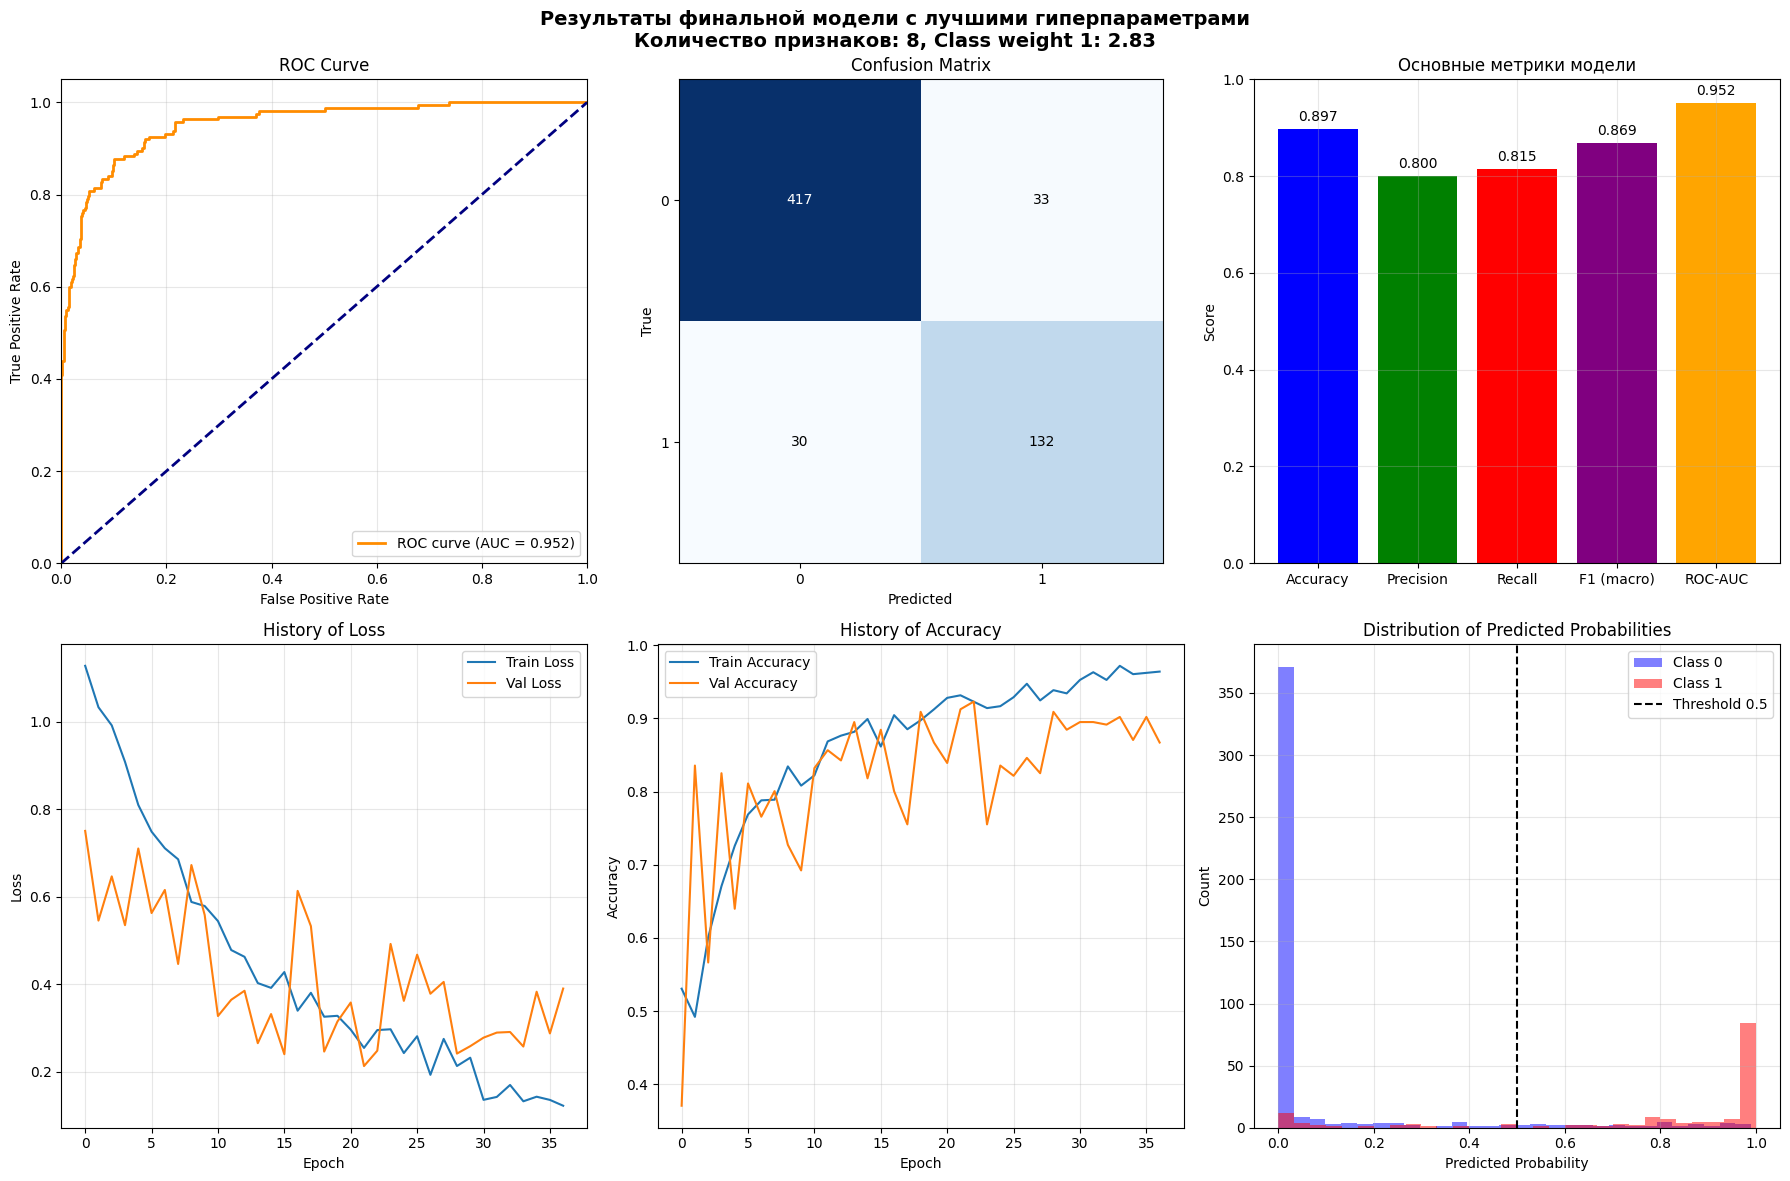


АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА ПРИЗНАКОВ НА КАЧЕСТВО

Статистика по количеству признаков:
Features   Trials     Avg F1     Avg AUC   
3          4          0.9399     0.9845
4          3          0.7541     0.8676
5          1          0.4871     0.7012
6          2          0.7301     0.7764
7          4          0.3651     0.6606
8          5          0.9105     0.9601
9          7          0.9338     0.9848
10         4          0.7612     0.8753

Финальная модель сохранена как 'best_cnn_model_optuna.h5'

Информация о лучших гиперпараметрах сохранена в 'best_hyperparameters.json'


In [6]:
# Объединяем train и val для кросс-валидации
X_cv = np.concatenate([X_train_cnn, X_val_cnn], axis=0)
y_cv = np.concatenate([y_train, y_val], axis=0)

print(f"Данные для кросс-валидации:")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"Баланс классов: 0={np.sum(y_cv==0)} ({np.sum(y_cv==0)/len(y_cv)*100:.1f}%), "
      f"1={np.sum(y_cv==1)} ({np.sum(y_cv==1)/len(y_cv)*100:.1f}%)")

# Функция для создания модели с заданными гиперпараметрами
def create_model_with_hyperparams(trial, input_shape):
    # Гиперпараметры из trial
    # Архитектурные параметры
    conv1_filters = trial.suggest_int('conv1_filters', 16, 128, step=16)
    conv2_filters = trial.suggest_int('conv2_filters', 32, 256, step=32)
    conv3_filters = trial.suggest_int('conv3_filters', 64, 512, step=64)
    
    # Количество извлекаемых признаков (наш ключевой параметр!)
    num_features = trial.suggest_int('num_features', 3, 10)  # от 3 до 10 признаков
    
    # Регуляризация
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # Размеры слоев классификатора
    feature_units = trial.suggest_int('feature_units', 16, 128, step=16)
    classifier_units1 = trial.suggest_int('classifier_units1', 8, 64, step=8)
    classifier_units2 = trial.suggest_int('classifier_units2', 4, 32, step=4)
    
    # Оптимизационные параметры
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    
    # Веса классов для дисбаланса
    class_weight_1 = trial.suggest_float('class_weight_1', 1.0, 5.0)  # Вес для класса 1
    
    # Создаем модель
    model = models.Sequential()
    
    # Блок 1
    model.add(layers.Conv2D(conv1_filters, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate * 0.8))  # Меньше dropout в начале
    
    # Блок 2
    model.add(layers.Conv2D(conv2_filters, (3, 3), padding='same', activation='relu'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    
    # Блок 3
    model.add(layers.Conv2D(conv3_filters, (3, 3), padding='same', activation='relu'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    
    # Извлечение признаков (переменное количество!)
    model.add(layers.Dense(feature_units, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate + 0.1))  # Больше dropout перед bottleneck
    model.add(layers.Dense(num_features, activation=None, name='features'))
    
    # Классификационная головка (простая)
    model.add(layers.Dense(classifier_units1, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate * 0.7))
    model.add(layers.Dense(classifier_units2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Выбор оптимизатора
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:  # rmsprop
        optimizer = RMSprop(learning_rate=learning_rate)
    
    # Компиляция
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model, class_weight_1

# Objective функция для Optuna
def objective(trial):
    """Целевая функция для оптимизации гиперпараметров с кросс-валидацией"""
    
    # Создаем модель с предложенными гиперпараметрами
    input_shape = X_train_cnn.shape[1:]
    model, class_weight_1 = create_model_with_hyperparams(trial, input_shape)
    
    # Кросс-валидация
    n_splits = 3  # Используем 3 фолда для скорости (можно увеличить)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    cv_scores_f1 = []
    cv_scores_auc = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv)):
        # Разделение данных
        X_train_fold = X_cv[train_idx]
        y_train_fold = y_cv[train_idx]
        X_val_fold = X_cv[val_idx]
        y_val_fold = y_cv[val_idx]
        
        # Веса классов для дисбаланса
        class_weight = {0: 1.0, 1: class_weight_1}
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=trial.suggest_int('early_stopping_patience', 5, 15),
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=trial.suggest_int('reduce_lr_patience', 3, 8),
                min_lr=1e-6,
                verbose=0
            )
        ]
        
        # Обучение
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=50,
            batch_size=trial.suggest_int('batch_size', 16, 64, step=16),
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=0
        )
        
        # Предсказания на валидации
        y_val_pred_proba = model.predict(X_val_fold, verbose=0).flatten()
        y_val_pred = (y_val_pred_proba > 0.5).astype(int)
        
        # Метрики для этого фолда
        fold_f1 = f1_score(y_val_fold, y_val_pred, average='macro')
        fold_auc = roc_auc_score(y_val_fold, y_val_pred_proba)
        
        cv_scores_f1.append(fold_f1)
        cv_scores_auc.append(fold_auc)
        
        # Отчет для pruning (досрочной остановки)
        trial.report(np.mean(cv_scores_f1), fold)
        
        # Проверка на pruning
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Вычисляем средние метрики по фолдам
    mean_f1 = np.mean(cv_scores_f1)
    mean_auc = np.mean(cv_scores_auc)
    
    # Сохраняем пользовательские атрибуты
    trial.set_user_attr('mean_auc', float(mean_auc))
    trial.set_user_attr('cv_scores_f1', [float(x) for x in cv_scores_f1])
    trial.set_user_attr('cv_scores_auc', [float(x) for x in cv_scores_auc])
    trial.set_user_attr('num_features', trial.params['num_features'])
    
    # Возвращаем комбинированный score (можно оптимизировать и F1, и AUC)
    # Используем среднее F1 и AUC как целевую метрику
    combined_score = (mean_f1 + mean_auc) / 2
    return combined_score

# Создаем study для Optuna
print(f"\n{'='*60}")
print("НАЧИНАЕМ ОПТИМИЗАЦИЮ ГИПЕРПАРАМЕТРОВ С OPTUNA")
print(f"{'='*60}")

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10,
        interval_steps=1
    ),
    study_name='cnn_hyperparameter_tuning'
)

# Запускаем оптимизацию
n_trials = 30  # Количество trial'ов
print(f"\nЗапускаем {n_trials} trial'ов оптимизации...")

study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Выводим результаты оптимизации
print(f"\n{'='*60}")
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ")
print(f"{'='*60}")

print(f"Лучший trial:")
print(f"  Номер: {study.best_trial.number}")
print(f"  Значение (combined score): {study.best_trial.value:.4f}")
print(f"  Macro F1: {np.mean(study.best_trial.user_attrs['cv_scores_f1']):.4f}")
print(f"  ROC-AUC: {study.best_trial.user_attrs['mean_auc']:.4f}")

print(f"\nЛучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Визуализация результатов Optuna
print(f"\n{'='*60}")
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ OPTUNA")
print(f"{'='*60}")

try:
    import optuna.visualization as vis
    
    # История оптимизации
    fig1 = vis.plot_optimization_history(study)
    fig1.show()
    
    # Важность гиперпараметров
    fig2 = vis.plot_param_importances(study)
    fig2.show()
    
    # Параллельные координаты
    fig3 = vis.plot_parallel_coordinate(study)
    fig3.show()
    
    # Зависимость метрики от гиперпараметров
    fig4 = vis.plot_slice(study)
    fig4.show()
    
except ImportError:
    print("Для визуализации установите plotly: pip install plotly")

# Обучаем финальную модель с лучшими гиперпараметрами на всех CV данных
print(f"\n{'='*60}")
print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ЛУЧШИМИ ГИПЕРПАРАМЕТРАМИ")
print(f"{'='*60}")

# Создаем финальную модель
final_model, final_class_weight = create_model_with_hyperparams(
    optuna.trial.FixedTrial(study.best_params), 
    X_train_cnn.shape[1:]
)

# Веса классов для финального обучения
class_weight = {0: 1.0, 1: final_class_weight}

# Обучаем на всех CV данных
final_history = final_model.fit(
    X_cv, y_cv,
    validation_split=0.2,
    epochs=100,
    batch_size=study.best_params['batch_size'],
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1)
    ],
    class_weight=class_weight,
    verbose=1
)

# Оценка на тестовых данных
print(f"\n{'='*60}")
print("ОЦЕНКА ФИНАЛЬНОЙ МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ")
print(f"{'='*60}")

# Предсказания на тестовом наборе
y_test_pred_proba = final_model.predict(X_test_cnn, verbose=0).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Все метрики
test_loss, test_acc = final_model.evaluate(X_test_cnn, y_test, verbose=0)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_binary = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Полный classification report
print("\nClassification Report для тестовых данных:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix для тестовых данных:")
print(cm_test)

# Детальные метрики
print(f"\nДетальные метрики на тестовых данных:")
print(f"Test Loss:        {test_loss:.4f}")
print(f"Test Accuracy:    {test_acc:.4f}")
print(f"Test Precision:   {test_precision:.4f}")
print(f"Test Recall:      {test_recall:.4f}")
print(f"Test F1 (binary): {test_f1_binary:.4f}")
print(f"Test F1 (macro):  {test_f1_macro:.4f}")
print(f"Test ROC-AUC:     {test_auc:.4f}")

# Визуализация кривой ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ROC Curve
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# Confusion Matrix
im1 = axes[0, 1].imshow(cm_test, cmap='Blues', interpolation='nearest')
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])
axes[0, 1].set_xticklabels(['0', '1'])
axes[0, 1].set_yticklabels(['0', '1'])

for i in range(2):
    for j in range(2):
        text = axes[0, 1].text(j, i, cm_test[i, j],
                             ha="center", va="center",
                             color="white" if cm_test[i, j] > cm_test.max()/2 else "black")

# Метрики
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 (macro)', 'ROC-AUC']
metrics_values = [test_acc, test_precision, test_recall, test_f1_macro, test_auc]
colors = ['blue', 'green', 'red', 'purple', 'orange']

bars1 = axes[0, 2].bar(metrics_names, metrics_values, color=colors)
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('Основные метрики модели')
axes[0, 2].set_ylim([0, 1])
axes[0, 2].grid(True, alpha=0.3)

for bar, value in zip(bars1, metrics_values):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

# История обучения (loss)
axes[1, 0].plot(final_history.history['loss'], label='Train Loss')
axes[1, 0].plot(final_history.history['val_loss'], label='Val Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('History of Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# История обучения (accuracy)
axes[1, 1].plot(final_history.history['accuracy'], label='Train Accuracy')
axes[1, 1].plot(final_history.history['val_accuracy'], label='Val Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('History of Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Распределение предсказанных вероятностей
axes[1, 2].hist(y_test_pred_proba[y_test == 0], bins=30, alpha=0.5, label='Class 0', color='blue')
axes[1, 2].hist(y_test_pred_proba[y_test == 1], bins=30, alpha=0.5, label='Class 1', color='red')
axes[1, 2].axvline(x=0.5, color='black', linestyle='--', label='Threshold 0.5')
axes[1, 2].set_xlabel('Predicted Probability')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Distribution of Predicted Probabilities')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Результаты финальной модели с лучшими гиперпараметрами\n'
             f'Количество признаков: {study.best_params["num_features"]}, '
             f'Class weight 1: {final_class_weight:.2f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Анализ важности количества признаков
print(f"\n{'='*60}")
print("АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА ПРИЗНАКОВ НА КАЧЕСТВО")
print(f"{'='*60}")

# Собираем информацию о количестве признаков и метриках
feature_counts = []
f1_scores = []
auc_scores = []

for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        if 'num_features' in trial.user_attrs:
            feature_counts.append(trial.user_attrs['num_features'])
            f1_scores.append(np.mean(trial.user_attrs['cv_scores_f1']))
            auc_scores.append(trial.user_attrs['mean_auc'])

if feature_counts:
    # Группируем по количеству признаков
    unique_features = sorted(set(feature_counts))
    feature_stats = {}
    
    for n_features in unique_features:
        indices = [i for i, x in enumerate(feature_counts) if x == n_features]
        avg_f1 = np.mean([f1_scores[i] for i in indices])
        avg_auc = np.mean([auc_scores[i] for i in indices])
        feature_stats[n_features] = {'avg_f1': avg_f1, 'avg_auc': avg_auc, 'count': len(indices)}
    
    print(f"\nСтатистика по количеству признаков:")
    print(f"{'Features':<10} {'Trials':<10} {'Avg F1':<10} {'Avg AUC':<10}")
    for n_features in unique_features:
        stats = feature_stats[n_features]
        print(f"{n_features:<10} {stats['count']:<10} {stats['avg_f1']:.4f}     {stats['avg_auc']:.4f}")

# Сохранение лучшей модели
final_model.save('best_models/best_cnn_model_optuna.h5')
print(f"\nФинальная модель сохранена как 'best_cnn_model_optuna.h5'")

# Сохранение информации о лучших гиперпараметрах
import json

best_params_info = {
    'best_params': study.best_params,
    'best_value': float(study.best_value),
    'best_trial_number': study.best_trial.number,
    'test_metrics': {
        'loss': float(test_loss),
        'accuracy': float(test_acc),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_macro': float(test_f1_macro),
        'f1_binary': float(test_f1_binary),
        'roc_auc': float(test_auc)
    }
}

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_params_info, f, indent=2)

print(f"\nИнформация о лучших гиперпараметрах сохранена в 'best_hyperparameters.json'")